# Случайный лес

В этом практическом задании вы решите задачу регрессии на реальных данных при помощи линейной модели и случайного леса. 

## Цели практической работы

* Научиться применять случайный лес в задаче регрессии.
* Научиться сравнивать качество случайного леса с качеством линейной модели.
* Научиться настраивать гиперпараметры леса.

## Что входит в работу

* Выполнить предобработку данных.
* Обучить линейную регрессию на данных задачи.
* Обучить случайный лес на данных задачи.
* Подобрать гиперпараметры для леса.
* Визуализировать важность признаков у леса.

## Что оценивается

*  Все ячейки заполнены; при запуске ячеек  Python не выдаёт информацию об ошибках.
*  Качество итоговой модели $R^2$ превышает 0,95.


## Что нужно сделать

Постройте модели, предсказывающие стоимость автомобилей по характеристикам.

Признаков у машин много, но в этой работе обойдёмся только числовыми признаками:
*  year — год производства автомобиля;
*  km_driven — пробег;
*  seats — количество посадочных мест;
*  mileage — другая характеристика пробега;
*  engine — мощность двигателя;
*  max_power — мощность автомобиля.

Целевая переменная — selling_price.

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("cars_train.csv")
test = pd.read_csv("cars_test.csv")

In [188]:
train.shape[0]

6998

In [190]:
train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,"Maruti Swift VXI BSIII,2007,130000,120000,Petr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hyundai Xcent 1.2 VTVT E Plus,2017.0,440000.0,45000.0,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


In [191]:
test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


Создайте объекты Xtrain, ytrain, Xtest, ytest. Запишите в них матрицы «объект — признак» и векторы целевой переменной для тренировочного и тестового датасетов.

In [195]:
X_train = train.drop("selling_price", axis=1)
X_test = test.drop("selling_price", axis=1)
y_train = train["selling_price"]
y_test = test["selling_price"]

В тренировочных данных есть автомобили, для которых неизвестна стоимость. Удалите эти автомобили из трейна.

In [197]:
y_train.isna().sum()

299

In [198]:
train_clean = train.dropna(subset=['selling_price'])

X_train = train_clean.drop("selling_price", axis=1)
y_train = train_clean["selling_price"]

In [199]:
y_train.isna().sum()

0

Перед обучением моделей обработайте данные.

Обратите внимание, что столбцы mileage, engine и max_power по смыслу числовые. Чтобы превратить их в числовые столбцы, отбросьте единицы измерения и оставьте только числа. В столбцах есть пропущенные значения, их при обработке трогать не нужно.

In [201]:
def extract_numeric_value(series):
    return series.str.extract(r'(\d+\.?\d*)').astype(float)

X_train['mileage'] = extract_numeric_value(X_train['mileage'])
X_test['mileage'] = extract_numeric_value(X_test['mileage'])

X_train['max_power'] = extract_numeric_value(X_train['max_power'])
X_test['max_power'] = extract_numeric_value(X_test['max_power'])

X_train['engine'] = extract_numeric_value(X_train['engine'])
X_test['engine'] = extract_numeric_value(X_test['engine'])

Оставьте в данных только шесть числовых столбцов:

year, km_driven, seats, engine, mileage, max_power

In [203]:
imp_features = ["year", "km_driven", "seats", "engine", "mileage", "max_power"]

X_train = X_train[imp_features]
X_test = X_test[imp_features]

Теперь заполните пропуски следующим образом:

*    вычислите средние значения по столбцам тренировочной выборки;

*    добавьте в пропуски в тренировочных и тестовых данных вычисленные средние.

In [205]:
X_train.isna().sum()

year           0
km_driven      0
seats        202
engine       202
mileage      202
max_power    196
dtype: int64

In [206]:
mean_seats = X_train['seats'].mean()
mean_mileage = X_train['mileage'].mean()
mean_max_power = X_train['max_power'].mean()
mean_engine = X_train['engine'].mean()
print(mean_seats, mean_mileage, mean_max_power, mean_engine)

5.4231183623210715 19.581199014929968 91.76898892818697 1455.6127443435432


In [208]:
X_train['seats'] = X_train['seats'].fillna(mean_seats)
X_train['mileage'] = X_train['mileage'].fillna(mean_mileage)
X_train['max_power'] = X_train['max_power'].fillna(mean_max_power)
X_train['engine'] = X_train['engine'].fillna(mean_engine)

X_test['seats'] = X_test['seats'].fillna(mean_seats)
X_test['mileage'] = X_test['mileage'].fillna(mean_mileage)
X_test['max_power'] = X_test['max_power'].fillna(mean_max_power)
X_test['engine'] = X_test['engine'].fillna(mean_engine)

In [210]:
X_train.isna().sum()

year         0
km_driven    0
seats        0
engine       0
mileage      0
max_power    0
dtype: int64

Теперь на обработанных тренировочных данных обучите:

*  линейную регрессию,
*  случайный лес с параметрами по умолчанию.

На обработанных тестовых данных сделайте предсказание и вычислите метрику $R^2$. 

In [212]:
lr = LinearRegression()
lr.fit(X_train, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear R²:   {r2_lr:.4f}")
print(f"Forest R²:   {r2_rf:.4f}")

Linear R²:   0.6486
Forest R²:   0.9630


Какая модель получилась лучше?

- Случайный лес лучше всего по метрикам получился

Улучшите качество предсказания случайного леса путём подбора гиперпараметров:

*   n_estimators,
*   max_depth,
*   max_features,
*   min_samples_leaf,
*   min_samples_split.

Для подбора гиперпараметров используйте GridSearchCV. Обучайте GridSearchCV по тренировочным данным с разбивкой на три фолда и метрикой $R^2$.

In [220]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

rf_tun = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_tun,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
max_depth: 20
max_features: 0.5
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200


Теперь обучите на тренировочных данных случайный лес с найденными гиперпараметрами. Сделайте предсказание на тестовых данных и оцените его качество ($R^2$).

In [222]:
best_rf = RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)

r2_best = r2_score(y_test, y_pred_best_rf)
round(r2_best, 4) # Лучше не куда было уже делать))

0.9625

Модель готова. Осталось её проинтерпретировать.

При помощи метода model.feature_importances_ визуализируйте гистограмму важности признаков у случайного леса с настроенными гиперпараметрами.

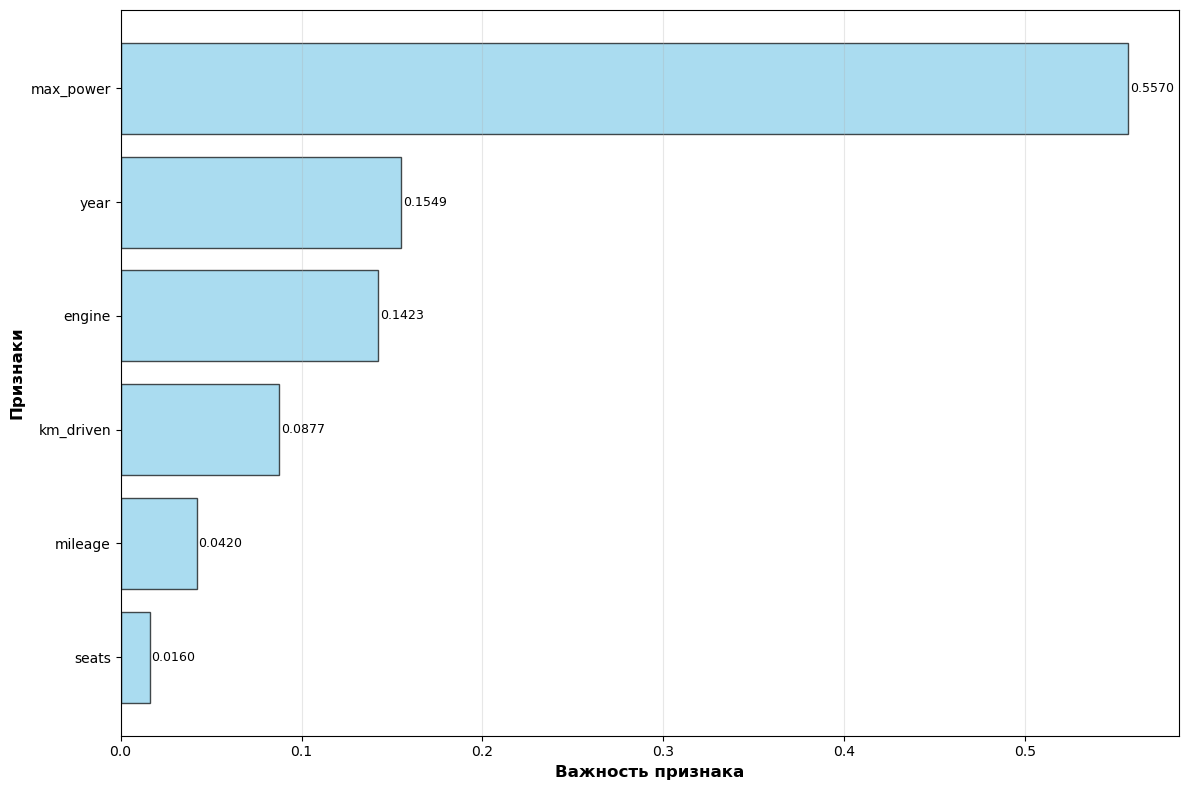

In [243]:
feature_importance = best_rf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))

bars = plt.barh(importance_df['feature'], importance_df['importance'], 
                color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Важность признака', fontsize=12, fontweight='bold')
plt.ylabel('Признаки', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis() 

for bar, importance in zip(bars, importance_df['importance']):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()